# Data extraction and merging


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
import os
import pickle
import codecs
import re
from tqdm import tqdm_notebook as tqdm

#For tokenizing sentences
import nltk
nltk.download('punkt')
plt.style.use('seaborn-whitegrid')

# Cte
BASE_PATH = "../data/"

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/salhilamia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/var/folders/my/5lwd7z794l5ch10f821f_jkm0000gn/T/ipykernel_17184/3106827710.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import codecs
import io
from lxml import etree
from dateutil.relativedelta import *

import seaborn as sns; sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import re
import pickle
from tqdm.notebook import tqdm

import nltk

## utils

### Reading the data

Nous avons 6 fichiers CSV :
- Statements : YES available right after each FOMC meeting
- Meeting Minutes : No because available three weeks after each FOMC meeting
- Press Conference Transcripts : YES to check
- Meeting Transcripts : NO available five years after the meeting
- Speeches : A considerer ça peut être interessant
- Testimony : 'Semiannual Monetary Policy Report to the Congress'

In [5]:
market_data_df = pd.read_csv("../data/dataset/agglomerate/agglomerate_fill_with_range_v2.csv", index_col=0)
market_data_sentiment = pd.read_csv("../data/dataset/agglomerate/agglomerate_filled_sentiment.csv")
columns = list(market_data_df.columns)

In [6]:
market_data_sentiment.columns

Index(['date', 'w.bcpi_BCPI_WEEKLY', 'w.bcne_BCPI_WEEKLY',
       'w.ener_BCPI_WEEKLY', 'w.mtls_BCPI_WEEKLY', 'w.fopr_BCPI_WEEKLY',
       'w.agri_BCPI_WEEKLY', 'w.fish_BCPI_WEEKLY', 'v39078_CA.-interest_rate',
       'v121820_U.S.-interest_rate', 'value_FRED_CPIAUCSL', 'value_FRED_DFF',
       'value_FRED_GDPC1', 'value_FRED_GDPPOT', 'value_FRED_HSN1F',
       'value_FRED_PAYEMS', 'value_FRED_PCEPILFE', 'value_FRED_RRSFS',
       'value_FRED_UNRATE', 'fxusdcad_FXUSDCAD_rsi', 'rsi_FXUSDCAD_rsi',
       'pmi_ISM_MAN_PMI', 'index_ISM_NONMAN_NMI', '1 mo_USTREASURY_YIELD',
       'canada_bank_sentiment_last_week', 'canada_bank_sentiment_last_2week',
       'canada_bank_sentiment_last_month',
       'fomc_statement_sentiment_last_week',
       'fomc_statement_sentiment_last_2week',
       'fomc_statement_sentiment_last_month',
       'fomc_meeting_sentiment_last_week', 'fomc_meeting_sentiment_last_2week',
       'fomc_meeting_sentiment_last_month', 'fomc_minutes_sentiment_last_week',
      

In [7]:
market_data_df = pd.read_csv("../data/dataset/agglomerate/agglomerate_fill_with_range_v2.csv", index_col=0)
market_data_sentiment = pd.read_csv("../data/dataset/agglomerate/agglomerate_filled_sentiment.csv")
columns = list(market_data_df.columns)

market_data_df = market_data_df.drop(columns[:20]+columns[20:], axis=1)
#market_data_df = market_data_df.drop(list(market_data_df.columns)[3:], axis=1)
market_data_df["date"] = market_data_sentiment["date"]
market_data_df["fxusdcad_FXUSDCAD_rsi"] = market_data_sentiment["fxusdcad_FXUSDCAD_rsi"]
market_data_df["fomc_statement_sentiment_last_week"] = market_data_sentiment["fomc_statement_sentiment_last_week"]
market_data_df["canada_bank_sentiment_last_week"] = market_data_sentiment["canada_bank_sentiment_last_week"]
#market_data_df["fomc_presconf_sentiment_last_week"] = market_data_sentiment["fomc_presconf_sentiment_last_week"]
#market_data_df["fomc_minutes_sentiment_last_week"] = market_data_sentiment["fomc_minutes_sentiment_last_week"]
market_data_df["fomc_testimony_sentiment_last_week"] = market_data_sentiment["fomc_testimony_sentiment_last_week"]
market_data_df.head()

,date,fxusdcad_FXUSDCAD_rsi,fomc_statement_sentiment_last_week,canada_bank_sentiment_last_week,fomc_testimony_sentiment_last_week
0,2017-01-04,1.331500,0.011111,0.014098,0.007442
1,2017-01-05,1.324400,0.022222,0.028195,0.014884
2,2017-01-06,1.321400,0.033333,0.042293,0.022326
3,2017-01-07,1.322267,0.044444,0.056391,0.029767
4,2017-01-08,1.323133,0.055556,0.070489,0.037209


## Evaluation

In [6]:
# fill nanq of market_data_df

In [8]:
import pandas as pd
from sklearn.metrics import mean_squared_error

def evaluate(pred_df: pd.DataFrame, test_path_csv: str) -> float:
    # Open test data
    test_df = pd.read_csv(test_path_csv)

    # Format data
    test_df['date'] = pd.to_datetime(test_df['date'], format='%Y-%m-%d')
    pred_df['date'] = pd.to_datetime(pred_df['date'], format='%Y-%m-%d')

    # Inner joint dataframe
    test_pred = test_df.merge(pred_df, on="date", how="inner")
    
    # Extract y true and y pred
    y_true = test_pred.FXUSDCAD_x.to_numpy()
    y_pred = test_pred.FXUSDCAD_y.to_numpy()

    mse = mean_squared_error(y_true, y_pred)
    print(f" Mean squared error: {mse}")

    # TODO: Add other metrics

    return mse

## remarks

Remarque sur les textes : 
- supprimer "[SECTION]", les "\n", les lists de nom de personnes du style "Jerome H. Powell, Chair; John C. Williams, Vice Chair; Michael S. Barr;"


List des mots redondants à supprimer (à plots):
- Committee
- les dates
- le début des textes

## heatmap

In [10]:
df2 = market_data_df.corr()

/var/folders/my/5lwd7z794l5ch10f821f_jkm0000gn/T/ipykernel_17184/3952367386.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df2 = market_data_df.corr()


In [11]:
import seaborn as sns
%matplotlib inline
sns.set(rc={'figure.figsize':(13,13)})
#df2 = df2.drop(market_data_df.columns[-11:]).drop(market_data_df.columns[-11:], axis=1)
#df2= df2.drop(market_data_df.columns[12]).drop(df_market_features.columns[12], axis=1)
#df2 = df2.drop(market_data_df.columns[13]).drop(df_market_features.columns[13], axis=1)

<AxesSubplot: title={'center': 'Correlation between market data'}>

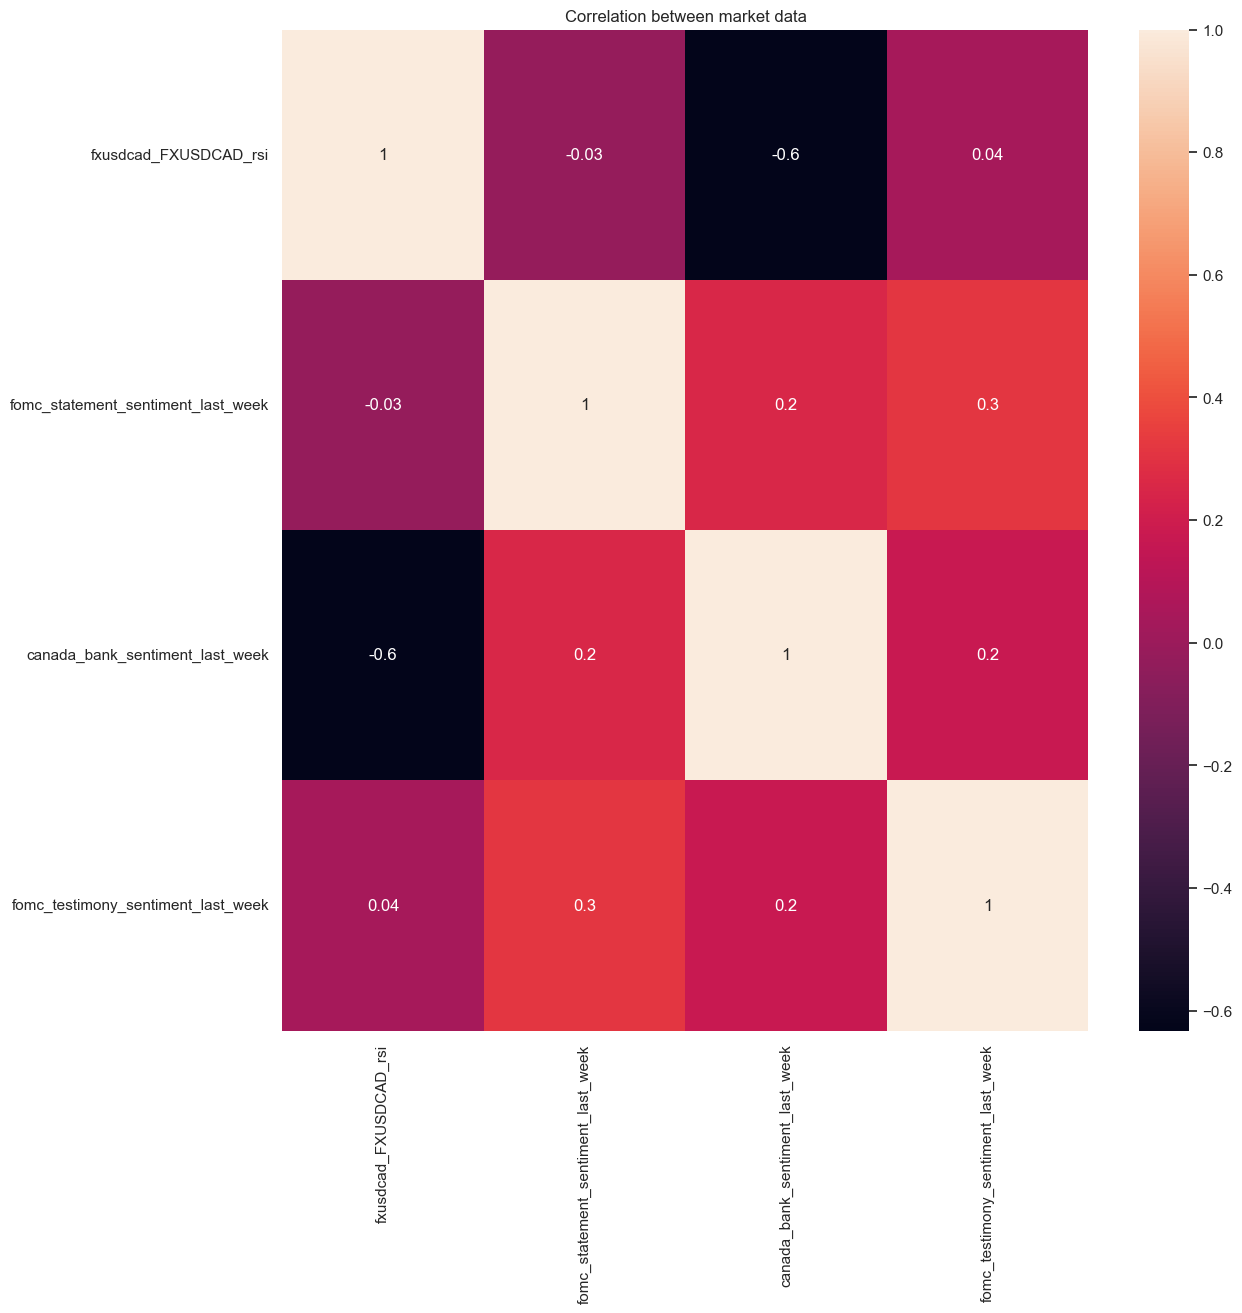

In [12]:
plt.title("Correlation between market data")
sns.heatmap(df2, annot=True, fmt=".1g")

## split train_test set

In [13]:
import pandas as pd
BASE_PATH = "../data"
def split_and_save(df: pd.DataFrame, date_split='2022-05-01', filename_prefix=None, output_path='', keep_index=False):
    """ Simple function to split data set """
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

    # Split data
    """ Train data """
    train = df.loc[(df['date'] < date_split)]
    """ Test data """
    test = df.loc[(df['date'] >= date_split)]
    
    # Save Value
    if filename_prefix != None:
        train.to_csv(f"{BASE_PATH}/train/{output_path}/{filename_prefix}.csv", index=keep_index)
        test.to_csv(f"{BASE_PATH}/test/{output_path}/{filename_prefix}.csv", index=keep_index)
    
    return train, test


In [14]:
train, test = split_and_save(market_data_df,filename_prefix="dataset", output_path="version1")

## preprocess

In [15]:
X_train, y_train = train.drop(['fxusdcad_FXUSDCAD_rsi','date'], axis=1).to_numpy(),train['fxusdcad_FXUSDCAD_rsi'].values
X_test, y_test = test.drop(['fxusdcad_FXUSDCAD_rsi','date'], axis=1).to_numpy(),test['fxusdcad_FXUSDCAD_rsi'].values

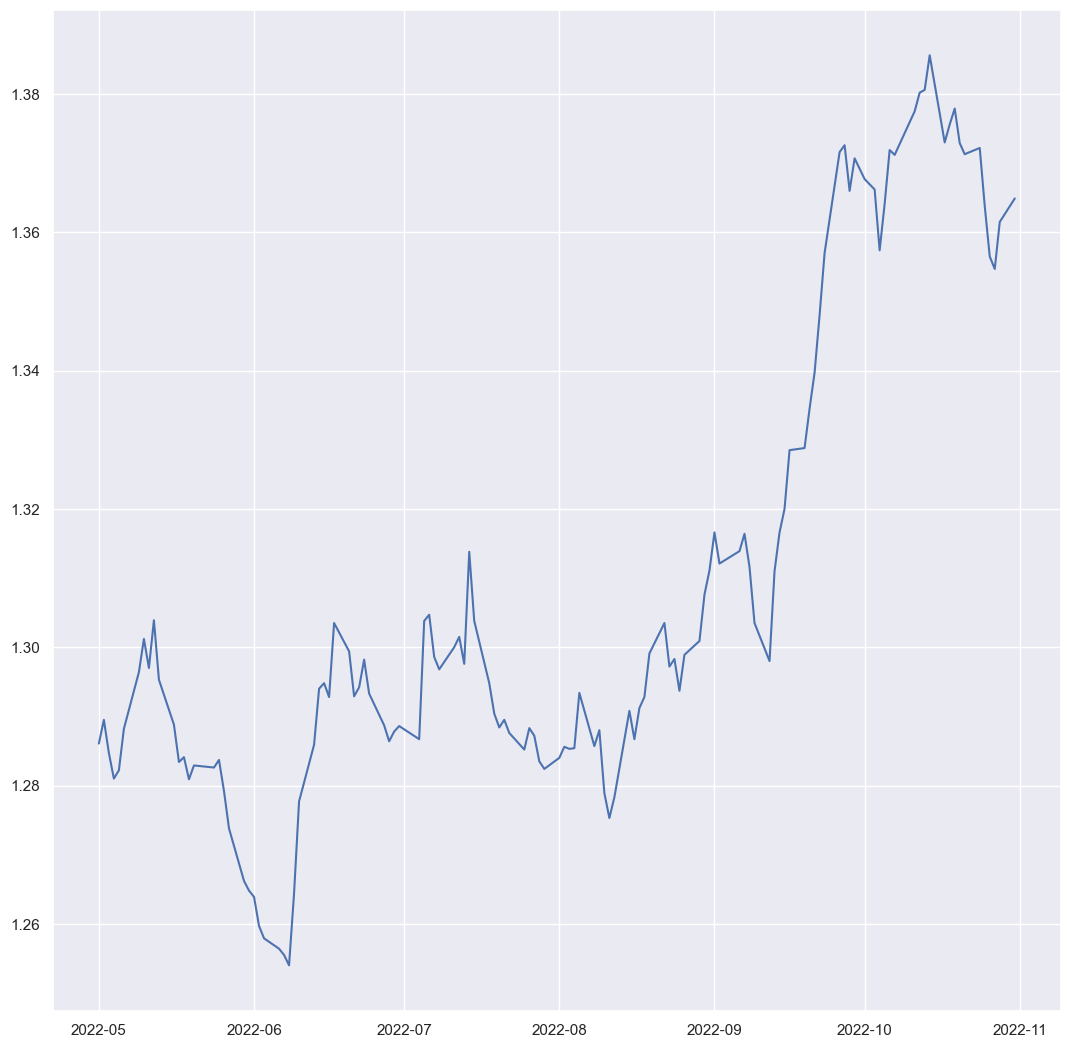

In [16]:
#cv_acc_std.append(cv_result['test_accuracy'].std())
dataframes_scores = []
dataframes_scores_test = []


## MODELS

### model simple XGboost

In [17]:
import xgboost
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
print(xgboost.__version__)

1.7.1


In [18]:
model = XGBRegressor(n_estimators=1000, max_depth=5, eta=0.1, subsample=0.7, colsample_bytree=0.8)

In [19]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(model, np.array(X_train), y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_r2 = cross_val_score(model, np.array(X_train), y_train, scoring='r2', cv=cv, n_jobs=-1)

In [20]:
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
print('Mean R2: %.3f (%.3f)' % (scores_r2.mean(), scores_r2.std()) )

model_name = "XGBRegressor"
mean_squared_error_mean = scores.mean()
mean_squared_error_std = scores.std()
R2_mean = scores_r2.mean()
R2_std = scores_r2.std()
dataframes_scores.append([model_name,mean_squared_error_mean,mean_squared_error_std,R2_mean, R2_std])


Mean MAE: 0.006 (0.000)
Mean R2: 0.949 (0.011)


In [21]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.100000001, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', ...)

In [22]:
y_test_pred  = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [35]:
mse = mean_squared_error(y_train, y_train_pred)
string_score = f"MSE on training set: {mse:.7f} "
mse = mean_squared_error(y_test, y_test_pred)
string_score += f"\nMSE on testing set: {mse:.7f} "

In [36]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
print(f" Mean squared error: {mse}\n r2 score: {r2}")

 Mean squared error: 0.000418467031647579
 r2 score: 0.622469729311272


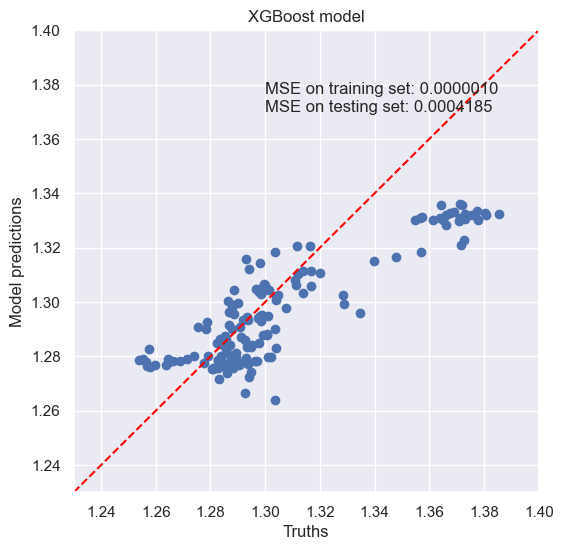

In [47]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_test_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.text(1.3, 1.37, string_score)

plt.title("XGBoost model")
plt.ylabel("Model predictions")
plt.xlabel("Truths")
plt.xlim([1.23, 1.4])
_ = plt.ylim([1.23, 1.4])

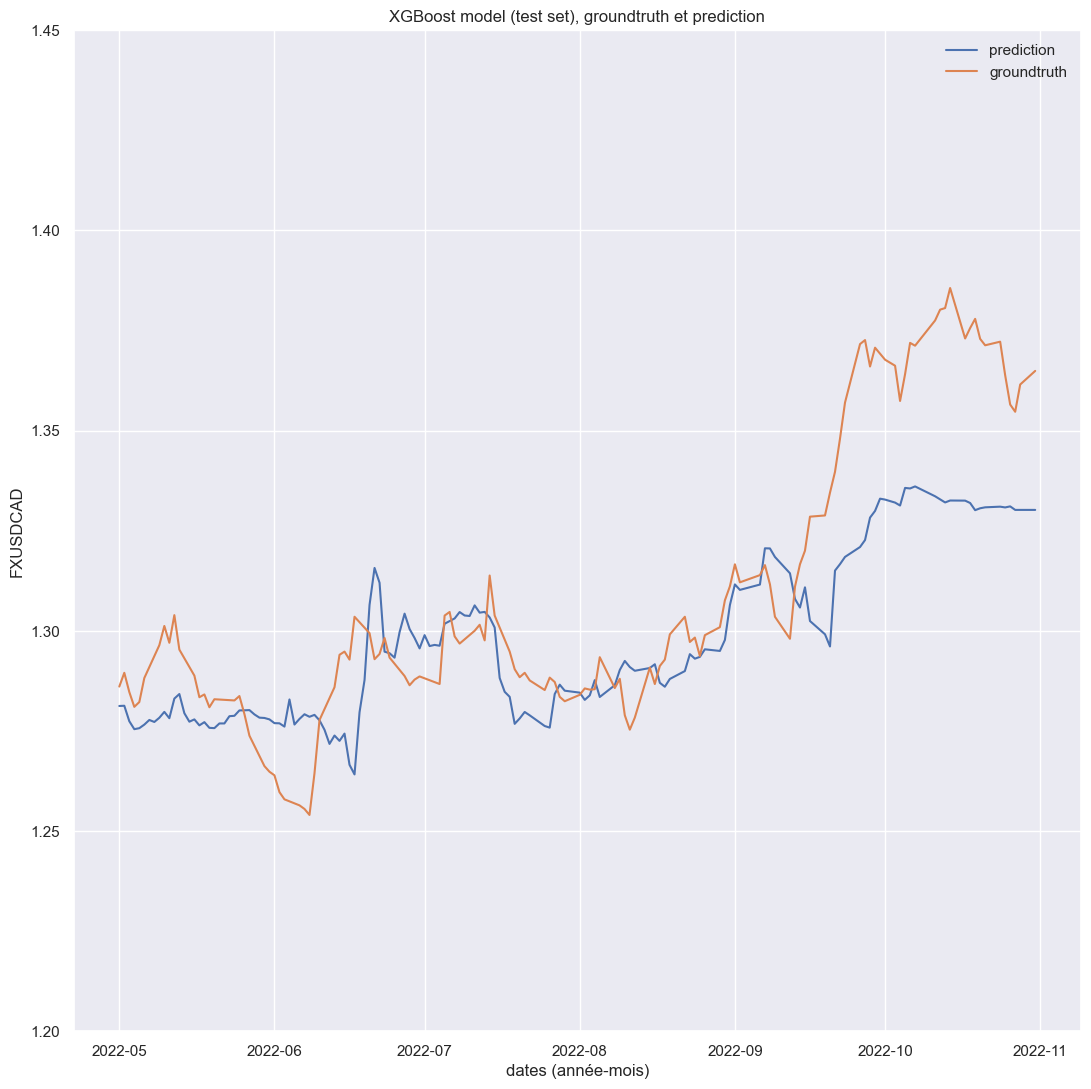

In [59]:
#import plotly.express as px
plt.title("XGBoost model (test set), groundtruth et prediction")
plt.ylabel("FXUSDCAD")
plt.xlabel("dates (année-mois)")

plt.plot(test['date'], y_test_pred, label='prediction')
plt.plot(test['date'], y_test,label='groundtruth')

_ = plt.ylim([1.20, 1.45])
plt.legend()
plt.show()

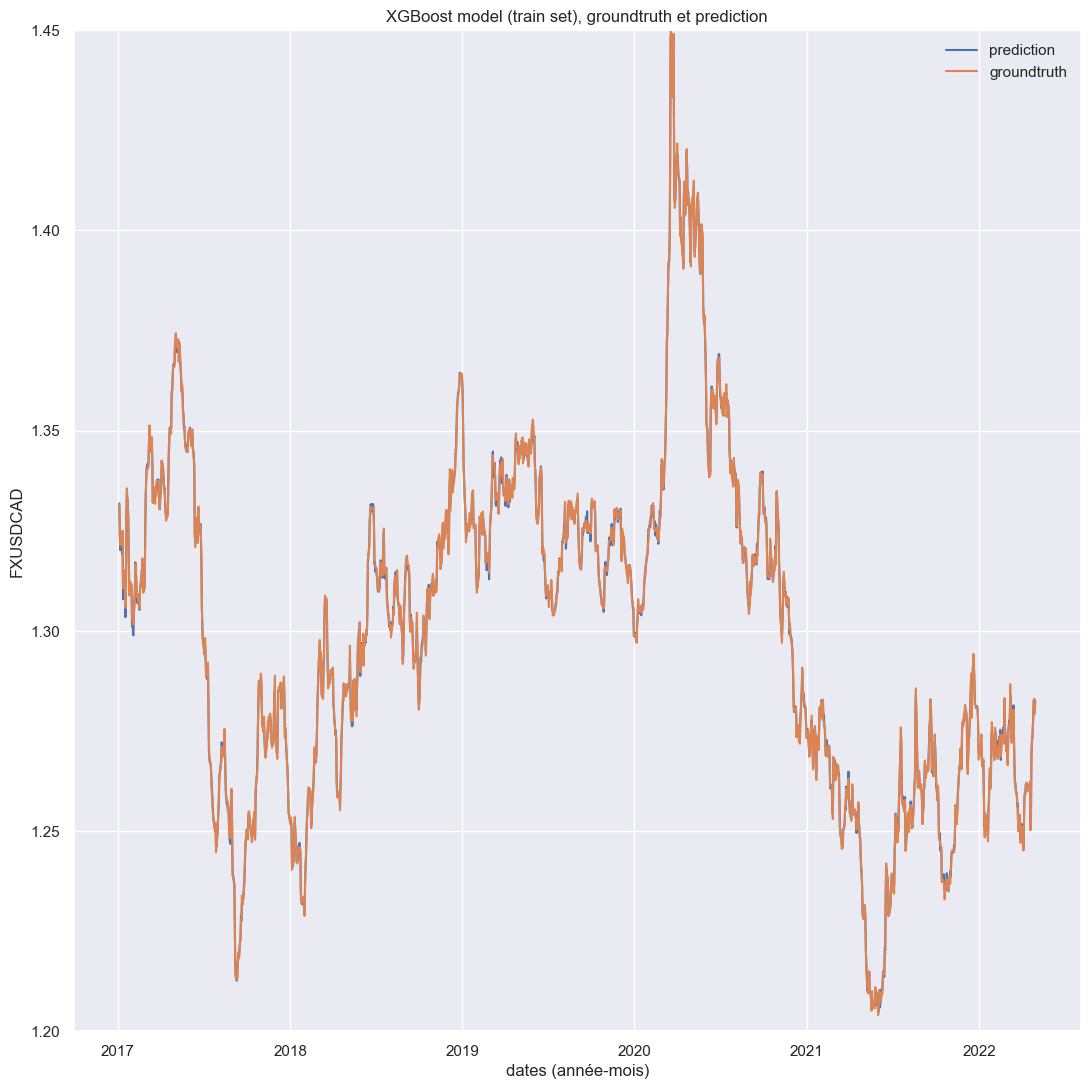

In [60]:
#import plotly.express as px
plt.title("XGBoost model (train set), groundtruth et prediction")
plt.ylabel("FXUSDCAD")
plt.xlabel("dates (année-mois)")

plt.plot(train['date'], y_train_pred, label='prediction')
plt.plot(train['date'], y_train,label='groundtruth')
_ = plt.ylim([1.20, 1.45])
plt.legend()
plt.show()

In [25]:
dataframes_scores_test.append([model_name, r2, mse,r2_score(y_train, y_train_pred), mean_squared_error(y_train, y_train_pred)])

### Random forest

In [26]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_depth=7, random_state=0, n_estimators=100)

In [27]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(model, np.array(X_train), y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_r2 = cross_val_score(model, np.array(X_train), y_train, scoring='r2', cv=cv, n_jobs=-1)

In [28]:
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
print('Mean R2: %.3f (%.3f)' % (scores_r2.mean(), scores_r2.std()) )

model_name = "RandomForestRegressor"
mean_squared_error_mean = scores.mean()
mean_squared_error_std = scores.std()
R2_mean = scores_r2.mean()
R2_std = scores_r2.std()
dataframes_scores.append([model_name,mean_squared_error_mean,mean_squared_error_std,R2_mean, R2_std])

Mean MAE: 0.010 (0.001)
Mean R2: 0.865 (0.012)


In [29]:
X_train.shape

(1943, 3)

In [30]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, random_state=0)

In [31]:
y_test_pred  = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [32]:
print(mean_squared_error(y_train, y_train_pred))
print(r2_score(y_train, y_train_pred))

0.00018543673791308847
0.8982915603760484


In [33]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
print(f" Mean squared error: {mse}\n r2 score: {r2}")

 Mean squared error: 0.0009887841991207365
 r2 score: 0.10794414346798986


In [34]:
dataframes_scores_test.append([model_name, r2, mse,r2_score(y_train, y_train_pred), mean_squared_error(y_train, y_train_pred)])

### Linear regression

In [35]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [36]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(model, np.array(X_train), y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_r2 = cross_val_score(model, np.array(X_train), y_train, scoring='r2', cv=cv, n_jobs=-1)

In [37]:
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
print('Mean R2: %.3f (%.3f)' % (scores_r2.mean(), scores_r2.std()) )

model_name = "LinearRegression"
mean_squared_error_mean = scores.mean()
mean_squared_error_std = scores.std()
R2_mean = scores_r2.mean()
R2_std = scores_r2.std()
dataframes_scores.append([model_name,mean_squared_error_mean,mean_squared_error_std,R2_mean, R2_std])

Mean MAE: 0.026 (0.001)
Mean R2: 0.435 (0.026)


In [38]:
model.fit(X_train, y_train)

LinearRegression()

In [39]:
y_test_pred  = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [40]:
mean_squared_error(y_train, y_train_pred)

0.001022872865252457

In [41]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
print(f" Mean squared error: {mse}\n r2 score: {r2}")

 Mean squared error: 0.0008383780458883189
 r2 score: 0.2436367343980822


In [42]:
dataframes_scores_test.append([model_name, r2, mse,r2_score(y_train, y_train_pred), mean_squared_error(y_train, y_train_pred)])

### SVR

In [43]:
from sklearn.svm import SVR
model = SVR(kernel="linear", coef0=1, C=0.1, epsilon=0.2)

In [44]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(model, np.array(X_train), y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_r2 = cross_val_score(model, np.array(X_train), y_train, scoring='r2', cv=cv, n_jobs=-1)

In [45]:
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
print('Mean R2: %.3f (%.3f)' % (scores_r2.mean(), scores_r2.std()) )

model_name = "SVR"
mean_squared_error_mean = scores.mean()
mean_squared_error_std = scores.std()
R2_mean = scores_r2.mean()
R2_std = scores_r2.std()
dataframes_scores.append([model_name,mean_squared_error_mean,mean_squared_error_std,R2_mean, R2_std])

Mean MAE: 0.039 (0.001)
Mean R2: -0.376 (0.055)


In [46]:
model.fit(X_train, y_train)

SVR(C=0.1, coef0=1, epsilon=0.2, kernel='linear')

In [47]:
y_test_pred  = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [48]:
mean_squared_error(y_train, y_train_pred)

0.0024975395771430196

In [49]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
print(f" Mean squared error: {mse}\n r2 score: {r2}")

 Mean squared error: 0.0015700181535947704
 r2 score: -0.4164302888549425


In [50]:
dataframes_scores_test.append([model_name, r2, mse,r2_score(y_train, y_train_pred), mean_squared_error(y_train, y_train_pred)])

### MLP Regressor

In [144]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [145]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [146]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=(100, 1000, 100), random_state=1, max_iter=500)

In [147]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(model, np.array(X_train), y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores_r2 = cross_val_score(model, np.array(X_train), y_train, scoring='r2', cv=cv, n_jobs=-1)

In [148]:
scores = absolute(scores)
model_name = "MLPRegressor"
mean_squared_error_mean = scores.mean()
mean_squared_error_std = scores.std()
R2_mean = scores_r2.mean()
R2_std = scores_r2.std()
dataframes_scores.append([model_name,mean_squared_error_mean,mean_squared_error_std,R2_mean, R2_std])

In [149]:
model.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(100, 1000, 100), max_iter=500, random_state=1)

In [57]:
y_test_pred  = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [58]:
mean_squared_error(y_train, y_train_pred)

0.00037640438975228925

In [59]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
print(f" Mean squared error: {mse}\n r2 score: {r2}")

 Mean squared error: 0.001093417677598839
 r2 score: 0.013546490927923371


In [60]:
dataframes_scores_test.append([model_name, r2, mse,r2_score(y_train, y_train_pred), mean_squared_error(y_train, y_train_pred)])

### LSTM

In [61]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

2022-11-09 20:38:23.485661: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [62]:
tf.random.set_seed(7)

In [116]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
testX = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [117]:
# create and fit the LSTM network
model = Sequential()
model.add(SimpleRNN(64, input_shape=(1, trainX.shape[2]), return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(trainX, y_train, epochs=100, batch_size=1, verbose=2)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_26 (SimpleRNN)   (None, 1, 64)             4352      
                                                                 
 simple_rnn_27 (SimpleRNN)   (None, 1, 32)             3104      
                                                                 
 dense_13 (Dense)            (None, 1, 1)              33        
                                                                 
Total params: 7,489
Trainable params: 7,489
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1943/1943 - 11s - loss: 0.0350 - 11s/epoch - 6ms/step
Epoch 2/100
1943/1943 - 5s - loss: 0.0045 - 5s/epoch - 3ms/step
Epoch 3/100
1943/1943 - 7s - loss: 0.0039 - 7s/epoch - 4ms/step
Epoch 4/100
1943/1943 - 8s - loss: 0.0020 - 8s/epoch - 4ms/step
Epoch 5/100
1943/1943 - 5s - loss: 0.0019 - 5s/epoch - 3m

In [97]:
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)

scores = []
scores_r2 = []
for train, test in cv.split(trainX, y_train):
	# create model
	model = Sequential()
	model.add(SimpleRNN(64, input_shape=(1, trainX[train].shape[2]), return_sequences=True))
	model.add(SimpleRNN(32, return_sequences=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	#model.summary()
	model.fit(trainX[train], y_train[train], epochs=40, batch_size=1)
	# evaluate the model
	y_test_pred  = model.predict(trainX[test])
	#y_train_pred = model.predict(trainX[train])

	mse_cv = mean_squared_error(y_train[test], y_test_pred.reshape(-1))
	r2_cv = r2_score(y_train[test], y_test_pred.reshape(-1))

	#print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
	scores.append(mse_cv)
	scores_r2.append(r2_cv)
	print("done")

Epoch 1/40
1554/1554 [==============================] - 11s 5ms/step - loss: 0.0449
Epoch 2/40
1554/1554 [==============================] - 7s 5ms/step - loss: 0.0042
Epoch 3/40
1554/1554 [==============================] - 7s 5ms/step - loss: 0.0040
Epoch 4/40
1554/1554 [==============================] - 7s 5ms/step - loss: 0.0025
Epoch 5/40
1554/1554 [==============================] - 7s 5ms/step - loss: 0.0023
Epoch 6/40
1554/1554 [==============================] - 6s 4ms/step - loss: 0.0020
Epoch 7/40
1554/1554 [==============================] - 7s 4ms/step - loss: 0.0017
Epoch 8/40
1554/1554 [==============================] - 10s 6ms/step - loss: 0.0015
Epoch 9/40
1554/1554 [==============================] - 7s 4ms/step - loss: 0.0015
Epoch 10/40
1554/1554 [==============================] - 9s 6ms/step - loss: 0.0014
Epoch 11/40
1554/1554 [==============================] - 9s 6ms/step - loss: 0.0013
Epoch 12/40
1554/1554 [==============================] - 8s 5ms/step - loss: 0.0012

In [100]:
model_name = "LSTM"
mean_squared_error_mean = np.array(scores).mean()
mean_squared_error_std = np.array(scores).std()
R2_mean = np.array(scores_r2).mean()
R2_std = np.array(scores_r2).std()
dataframes_scores.append([model_name,mean_squared_error_mean,mean_squared_error_std,R2_mean, R2_std])

In [118]:
y_test_pred  = model.predict(testX)
y_train_pred = model.predict(trainX)

61/61 [==============================] - 0s 5ms/step


In [119]:
print(mean_squared_error(y_train, y_train_pred.reshape(-1)))
print(r2_score(y_train, y_train_pred.reshape(-1)))

0.000494175628787149
0.7289542909901539


In [120]:
print(mean_squared_error(y_test, y_test_pred.reshape(-1)))
print(r2_score(y_test, y_test_pred.reshape(-1)))

0.0010078228374528863
0.09076797010307225


In [ ]:
dataframes_scores_test.append([model_name,r2_score(y_test, y_test_pred.reshape(-1)),\
    mean_squared_error(y_test, y_test_pred.reshape(-1)),\
        r2_score(y_train, y_train_pred.reshape(-1)), \
            mean_squared_error(y_train, y_train_pred.reshape(-1))])

## ALL results

In [154]:
columns_name = ["model", "mean_squared_error_mean","mean_squared_error_std",\
     "R2_mean","R2_std"]

df_cv_results = pd.DataFrame(dataframes_scores, columns= columns_name)

In [155]:
df_cv_results

,model,mean_squared_error_mean,mean_squared_error_std,R2_mean,R2_std
0,XGBRegressor,0.005767,0.000439,0.949403,0.011261
1,RandomForestRegressor,0.010250,0.000515,0.864927,0.012111
2,LinearRegression,0.025555,0.000671,0.434743,0.026243
3,SVR,0.039400,0.000996,-0.375879,0.054590
4,LSTM,0.000726,0.000054,0.601165,0.021088
5,MLPRegressor,0.015611,0.000696,0.758100,0.024203


In [156]:
columns_name = ["model", "r2_test","mse_test",\
     "r2_train","mse_train"]

df_test_results = pd.DataFrame(dataframes_scores_test, columns= columns_name)

In [157]:
df_test_results

,model,r2_test,mse_test,r2_train,mse_train
0,XGBRegressor,0.622470,0.000418,0.999443,0.000001
1,RandomForestRegressor,0.107944,0.000989,0.898292,0.000185
2,LinearRegression,0.243637,0.000838,0.438974,0.001023
3,SVR,-0.416430,0.001570,-0.369852,0.002498
4,MLPRegressor,0.013546,0.001093,0.793550,0.000376
5,LSTM,0.090768,0.001008,0.728954,0.000494


In [158]:
df_cv_results.sort_values(by='mean_squared_error_mean', ascending=False).reset_index(drop=True)

,model,mean_squared_error_mean,mean_squared_error_std,R2_mean,R2_std
0,SVR,0.039400,0.000996,-0.375879,0.054590
1,LinearRegression,0.025555,0.000671,0.434743,0.026243
2,MLPRegressor,0.015611,0.000696,0.758100,0.024203
3,RandomForestRegressor,0.010250,0.000515,0.864927,0.012111
4,XGBRegressor,0.005767,0.000439,0.949403,0.011261
5,LSTM,0.000726,0.000054,0.601165,0.021088


Text(0.5, 1.0, 'MSE 5-fold Cross validation scores')

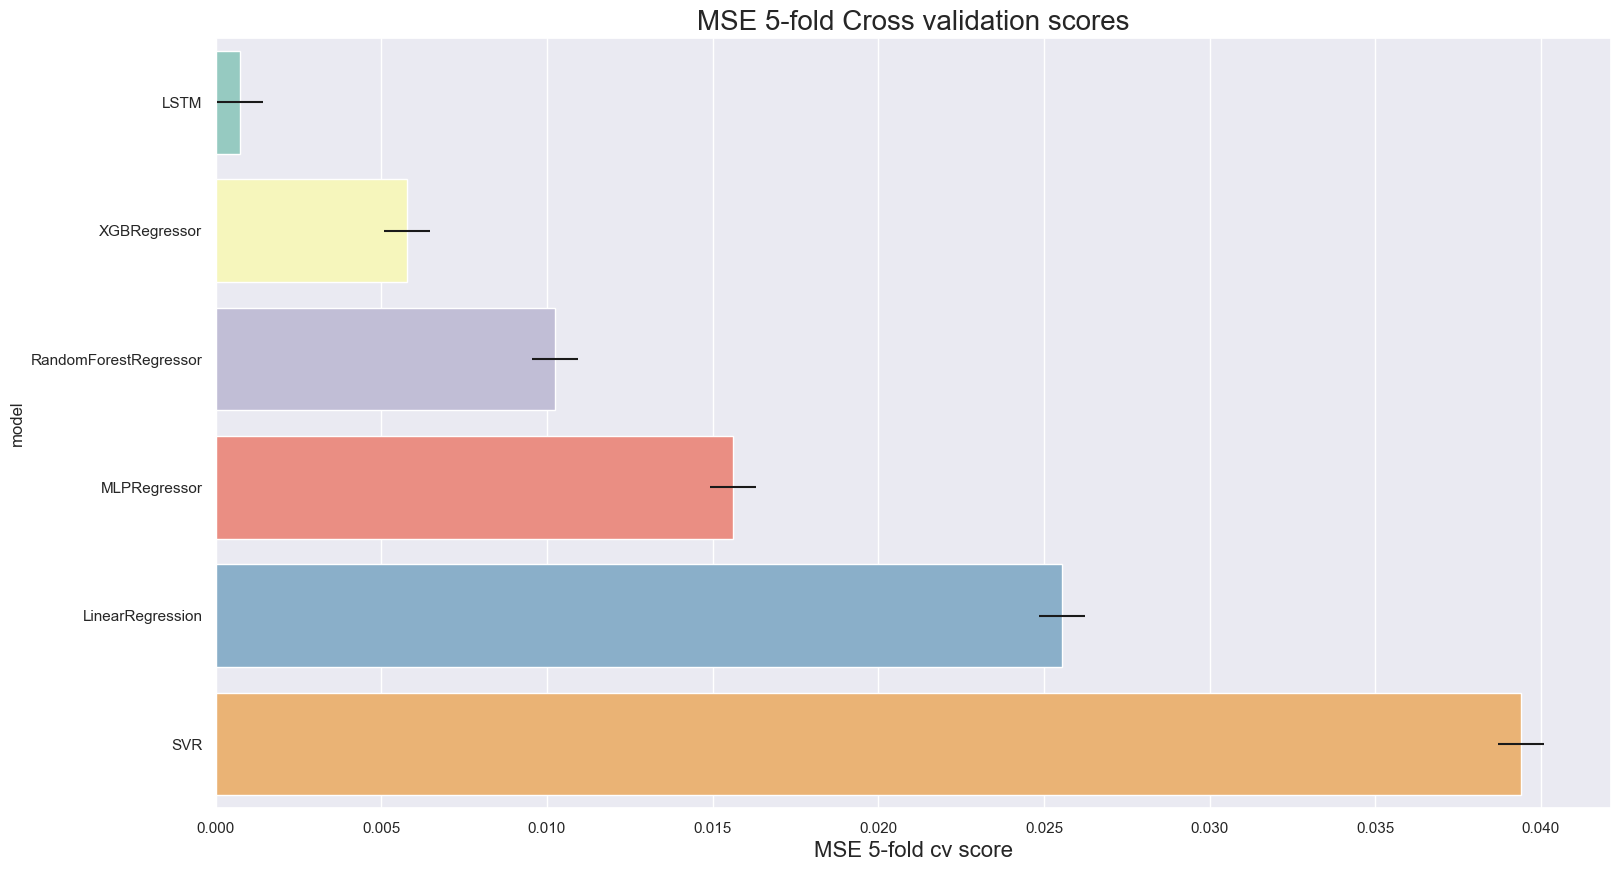

In [159]:
plt.figure(figsize=(18,10))
ax = sns.barplot(x = "mean_squared_error_mean",y="model",data=df_cv_results.sort_values(by='mean_squared_error_mean', ascending=True).reset_index(drop=True), palette="Set3", orient="h", **{'xerr':mean_squared_error_std})
ax.set_xlabel("MSE 5-fold cv score", size=16)
ax.set_title("MSE 5-fold Cross validation scores", size=20)

Text(0.5, 1.0, 'R2 5-fold Cross validation scores')

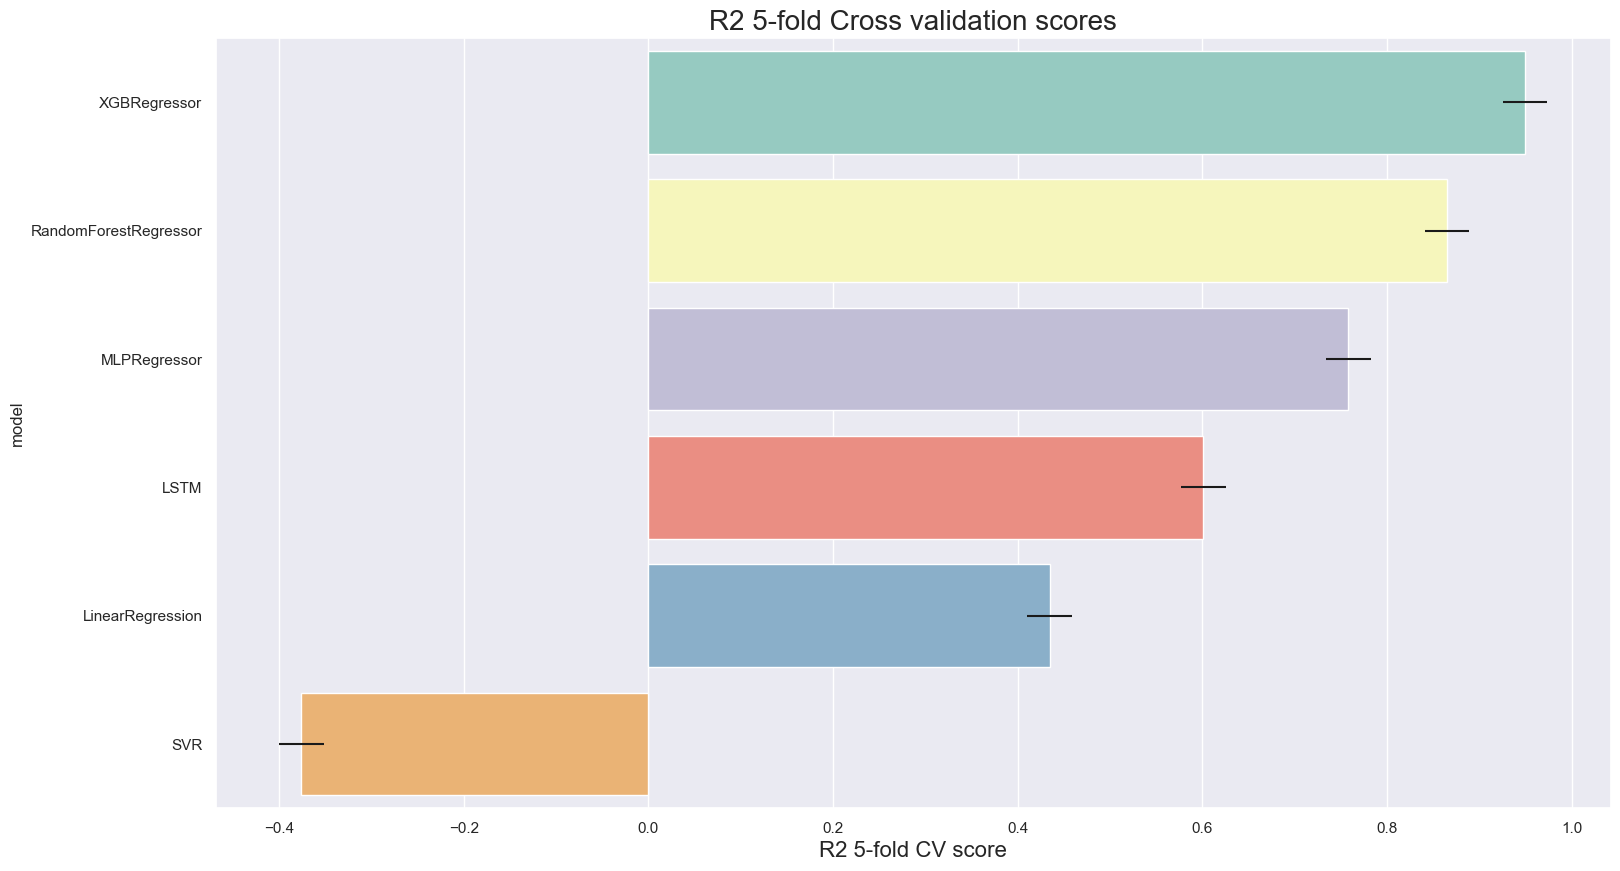

In [161]:
plt.figure(figsize=(18,10))
ax = sns.barplot(x = "R2_mean",y = "model",data=df_cv_results.sort_values(by='R2_mean', ascending=False), palette="Set3", orient="h", **{'xerr':R2_std})
ax.set_xlabel("R2 5-fold CV score", size=16)
ax.set_title("R2 5-fold Cross validation scores", size=20)

Text(0.5, 1.0, 'R2 test scores per model')

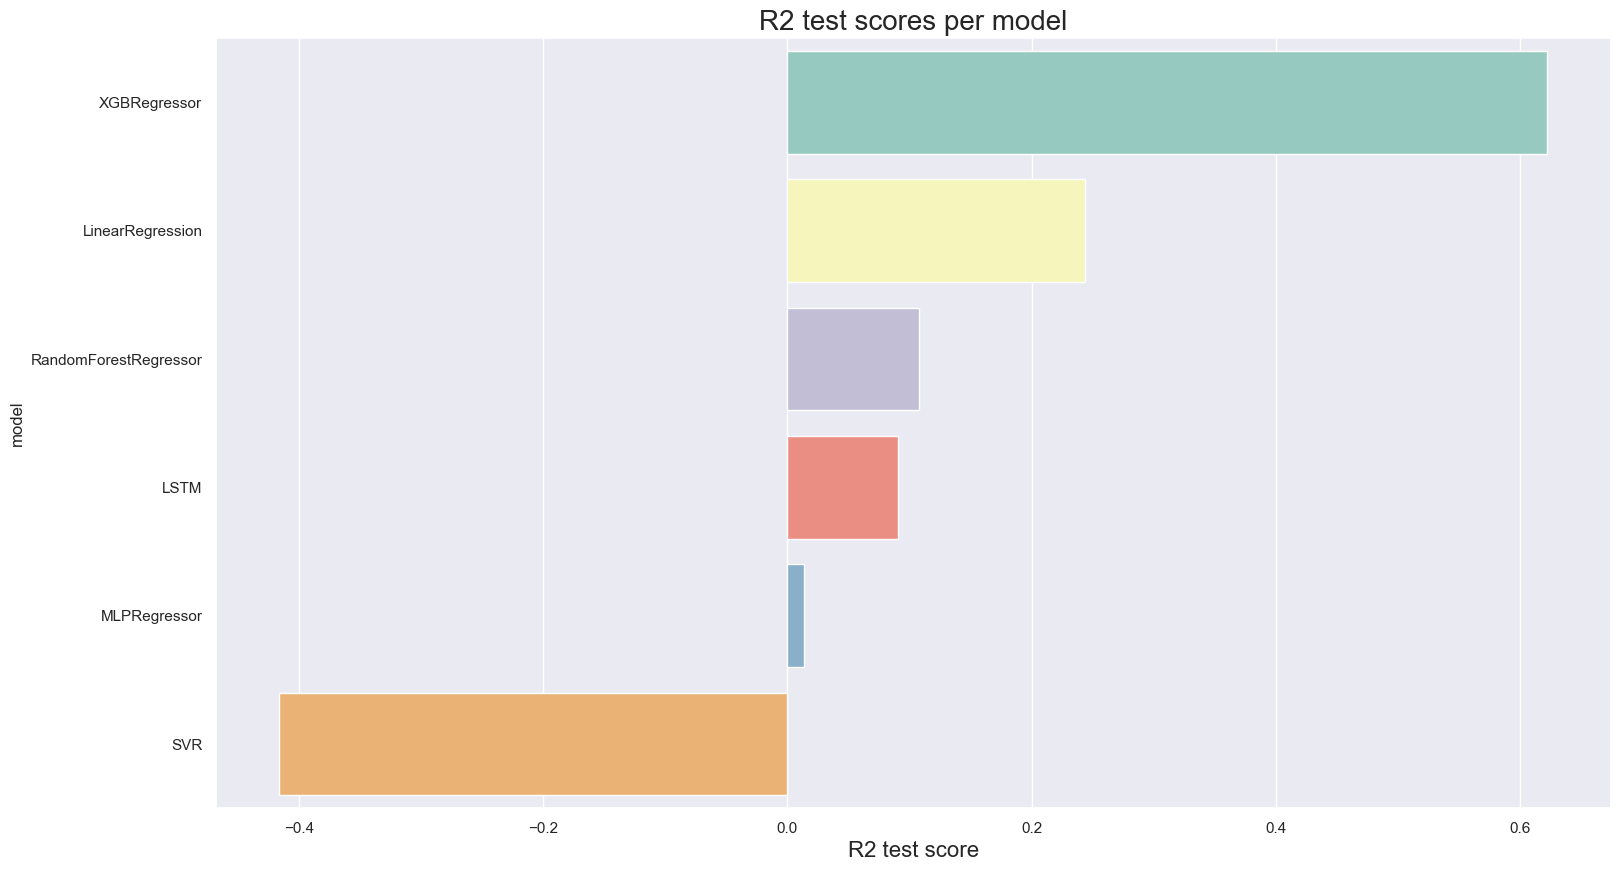

In [162]:
plt.figure(figsize=(18,10))
ax = sns.barplot(x = "r2_test",y = "model",data=df_test_results.sort_values(by='r2_test', ascending=False), palette="Set3", orient="h")
ax.set_xlabel("R2 test score", size=16)
ax.set_title("R2 test scores per model", size=20)

Text(0.5, 1.0, 'MSE test scores per model')

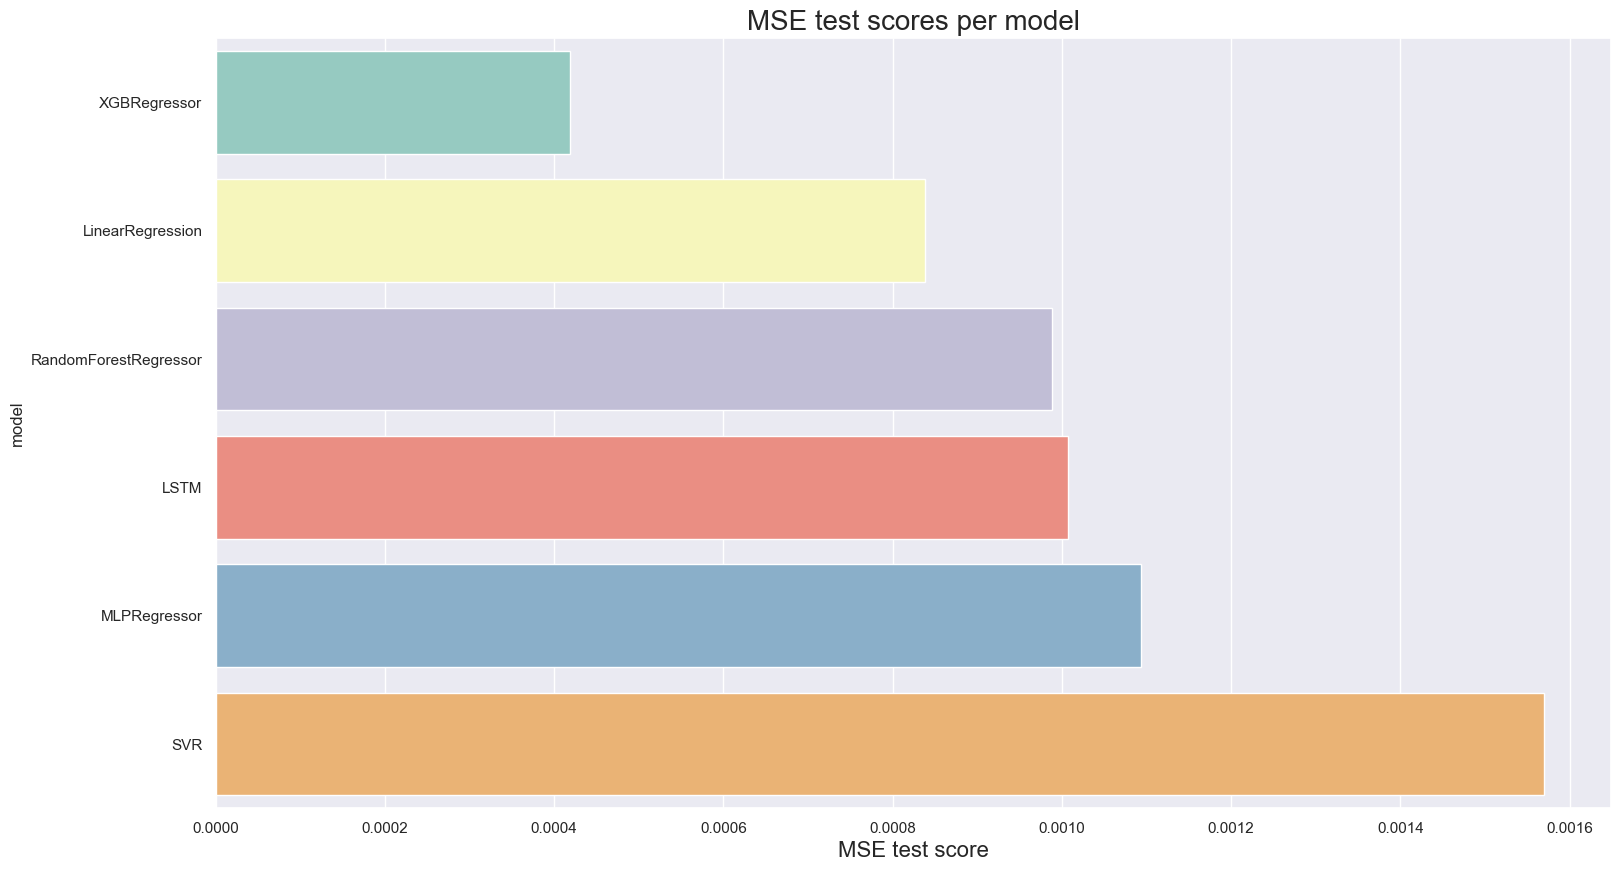

In [142]:
plt.figure(figsize=(18,10))
ax = sns.barplot(x = "mse_test",y = "model",data=df_test_results.sort_values(by='mse_test', ascending=True), palette="Set3", orient="h")
ax.set_xlabel("MSE test score", size=16)
ax.set_title("MSE test scores per model", size=20)